 ## CHIVI expts on linear regression in high dimensions

In [ ]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
import autograd
import pickle
import pystan

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       perturbed_black_box_vi,
                       make_stan_log_density,
                       adagrad_optimize, 
                     
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

In [ ]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [ ]:

regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(40, x * beta, 1);  // likelihood
  #y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [ ]:
try:
    sm = pickle.load(open('robust_reg_model_t.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_t.pkl', 'wb') as f:
        pickle.dump(sm, f)



### First we take D=14

In [ ]:
N=80
k=14
SEED= 5080
alpha=1.
noise_sigma=0.5
noise_var = noise_sigma**2
rho = 0.1
regression_data = data_generator_linear(N, k, alpha=alpha,noise_variance=noise_var,rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

In [19]:
lims1 = dict(xlim=[-1.7,0.1], ylim=[-0.2,1.2])
lims2 = dict(xlim=[1.7,3.2], ylim=[-1.1,0.2])

In [ ]:
#data = dict(N=N, x=x, y=y, D=k)
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [ ]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [ ]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 2000)
chivi_t_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 2000)
chivi_fr_objective_and_grad_pd = black_box_chivi(2, fr_g_var_family, stan_log_density, 2000)

In [ ]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

### KLVI solution

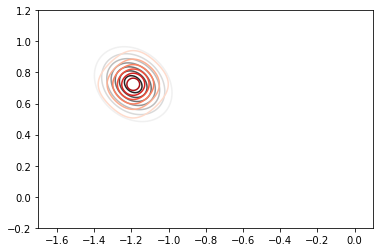

In [20]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims1,
                               savepath='figures/robust-regression-mf-klvi-good_new.pdf', aux_var = true_mean[2:])

#### make KLVI solution overdispersed

In [13]:
mf_t_var_family = mean_field_t_variational_family(k, 5)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
init_param1[k:] +=0.6

(28,)


In [14]:
a,b,c,d = adagrad_optimize(6000, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.01, learning_rate_end=0.002)

Average Loss = -24.505: 100%|██████████| 6000/6000 [04:52<00:00, 20.54it/s]


In [15]:
#a1,b1,c1,d1 = adagrad_optimize(600, chivi_objective_and_grad,  a, False, window=10, learning_rate=.01, learning_rate_end=0.002)

#### PLot of CUBO

[-1.19034345  0.72406217  1.62590646  0.50418485 -1.07319685  1.0014915
 -0.37777354  2.93361392 -0.67051274  0.09566705  1.07265575  1.12774601
 -2.26243252  0.37820983 -2.40413273 -2.26400633 -2.11455833 -2.26547025
 -2.30499035 -2.2563225  -2.31012922 -2.25712883 -2.36900823 -2.23745396
 -2.21724267 -2.3256001  -2.31147513 -2.32502565]
[-1.19249264  0.72322413  1.62559796  0.50317724 -1.07348236  1.00288886
 -0.37734303  2.93620308 -0.67019284  0.09492116  1.06961739  1.12904541
 -2.26359744  0.37593916 -2.19482295 -2.02436703 -1.92613319 -2.06694841
 -2.12606416 -2.08325124 -2.11960634 -2.09893995 -2.17317144 -2.03177024
 -1.99764101 -2.10549335 -2.14732685 -2.13061783]
[-1.19150618  0.72536987  1.62702478  0.50379905 -1.07336999  1.00511057
 -0.37778766  2.93404072 -0.670137    0.09659966  1.07378107  1.12850778
 -2.26431843  0.37810824]
[-2.1805432  -2.00439153 -1.89378467 -2.06439625 -2.11749726 -2.03001761
 -2.14862331 -2.08213827 -2.1515425  -2.02269947 -1.98944624 -2.10109846

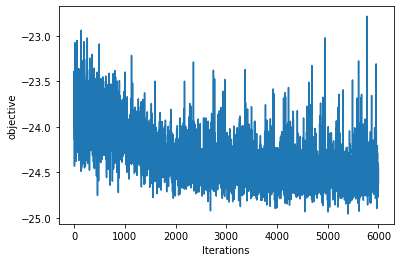

In [21]:
print(klvi_var_param)
print(a)
#print(b[-1])
print(true_mean)
print(np.log(true_std))

plt.plot(c)
plt.ylabel('objective')
plt.xlabel('Iterations')
plt.savefig('figures/good_chivi_run_new1.pdf')
print(c[0])
print(c[-1])

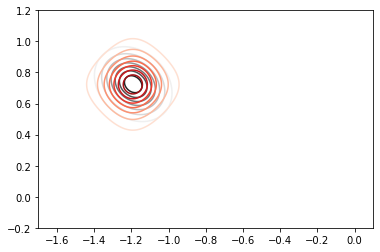

In [22]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a, **lims1,
                               savepath='figures/robust-regression-mf-chivi-good_new1.pdf', aux_var = true_mean[2:])

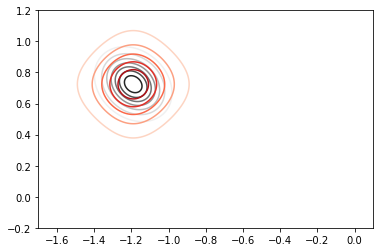

In [23]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_param1, **lims1,
                               savepath='figures/robust-regression-mf-chivi-init1.pdf', aux_var = true_mean[2:])

###  Bad run, let us take D=30

In [24]:
N=90
k=30
SEED= 5080
alpha=1.
noise_sigma=0.5
noise_var = noise_sigma**2
rho = 0.1
regression_data = data_generator_linear(N, k, alpha=alpha,noise_variance=noise_var,rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

In [25]:
#data = dict(N=N, x=x, y=y, D=k)
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [26]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [27]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 600)
chivi_t_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 600)
chivi_fr_objective_and_grad_pd = black_box_chivi(2, fr_g_var_family, stan_log_density, 600)

In [28]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 6000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 93.16: 100%|██████████| 6000/6000 [00:45<00:00, 132.86it/s] 


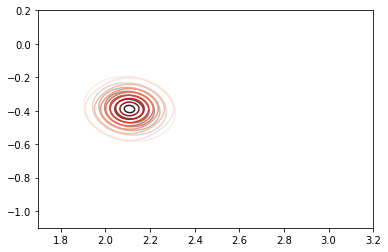

In [30]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims2,
                               savepath='figures/robust-regression-mf-klvi-bad_new_1.pdf', aux_var = true_mean[2:])

In [31]:
mf_t_var_family = mean_field_t_variational_family(k, 8)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
init_param1[k:] += 1.2

(60,)


In [48]:
a1,b1,c1,d1 = adagrad_optimize(1400, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.005, learning_rate_end=0.002)

Average Loss = -76.95: 100%|██████████| 1400/1400 [01:15<00:00, 18.60it/s] 


[ 2.107849   -0.38926655 -0.47548721  1.70539101  0.01792756  0.44905026
  0.08557676  0.12501176  1.05727024 -1.01071255 -0.27542239  0.51884498
 -0.82683913 -0.05545258 -1.56766917 -0.82879026 -0.45432806 -1.40039733
  0.05868357  0.95003692 -1.2903244  -0.34145529  0.26676693  0.08199261
 -1.03188473  0.20511306 -0.27190747 -0.4928862  -2.69851165  0.89668356
 -2.37374953 -2.42916877 -2.30843647 -2.38465948 -2.2720462  -2.21637637
 -2.38256208 -2.29955654 -2.37793525 -2.33755952 -2.29784835 -2.4992964
 -2.42387386 -2.26919082 -2.30351993 -2.42101311 -2.16790014 -2.33541616
 -2.3114862  -2.43847468 -2.37613036 -2.19522686 -2.40581461 -2.28425813
 -2.40418741 -2.45320112 -2.44171267 -2.27822173 -2.33484698 -2.42385857]
nan
[ 2.10611405 -0.38930639 -0.47878035  1.707778    0.01827786  0.44813089
  0.08597096  0.12486144  1.05777483 -1.00907218 -0.27542102  0.5166946
 -0.83259818 -0.05102942 -1.5670063  -0.82671188 -0.45277542 -1.40125571
  0.05675924  0.94964304 -1.29099565 -0.3481345 

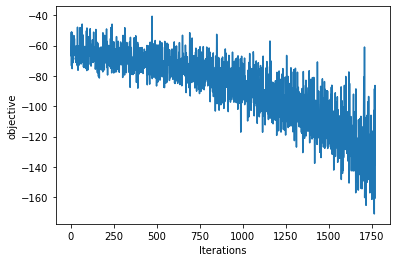

In [38]:
print(klvi_var_param)
print(a)
#print(b[-1])
print(true_mean)
print(np.log(true_std))

plt.plot(c)
plt.ylabel('objective')
plt.xlabel('Iterations')
plt.savefig('figures/bad_chivi_run_new1.pdf')
print(c[0])
print(c[-1])

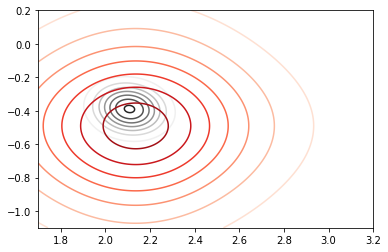

In [49]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, b1[-1], **lims2,
                               savepath='figures/robust-regression-mf-chivi-bad_new_1.pdf', aux_var = true_mean[2:])